## Internet speed generation notebook
### This particular notebook is aimed to process parquet from https://github.com/teamookla/ookla-open-data
### For succesfull filtering it is necessary alto provide desired country polygon and, internet speed tresholds (in case of new country)

In [95]:
import geopandas as gpd
import pandas as pd
import shapely
from tqdm import tqdm
from collections import Counter
import json

In [87]:
# define country name
country_name = "Kenya"

In [ ]:
# read downloaded parquet from afore mentioned GitHub
df = pd.read_parquet('2024-04-01_performance_fixed_tiles.parquet')
gdf = gpd.GeoDataFrame(df, geometry=shapely.from_wkt(df.tile))
gdf

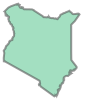

In [75]:
# desireed country boundaries polygon
boundaries_polygon = gpd.read_file('boundaries/Kenya_boundaries.json').geometry.iloc[-1]
boundaries_polygon

In [77]:
# filter tiles within country polygon
country_tiles = []

for row in tqdm(gdf.itertuples(), total=len(gdf)):
    
    if boundaries_polygon.contains(shapely.geometry.Point(row.tile_x, row.tile_y)):
        country_tiles.append(row)

100%|██████████| 6492072/6492072 [02:20<00:00, 46253.39it/s]


In [ ]:
country_tiles_df = pd.DataFrame(country_tiles)
country_tiles_df

In [83]:
country_tiles_gdf = gpd.GeoDataFrame(country_tiles_df, geometry=country_tiles_df.geometry)

In [ ]:
country_tiles_gdf.describe()

In [88]:
# speed_treshols for dividing into categories
# Kenya
# very_high, min speed: 45.564, max speed: 283.392
# high, min speed: 25.557, max speed: 45.506
# normal, min speed: 5.582, max speed: 25.527
# slow, min speed: 0.001, max speed: 5.578
# Maharashtra region
# very_high, min speed: 112.113, max speed: 430.98
# high, min speed: 72.002, max speed: 111.951
# normal, min speed: 31.836, max speed: 71.97
# slow, min speed: 11.771, max speed: 31.83
# very_slow, min speed: 0.004, max speed: 11.746

speed_treshols = {
    'Maharashtra': {
        'very_slow': [0, 11.746],
        'slow': [11.771, 31.83],
        'normal': [31.836, 71.97],
        'high': [72.002, 111.951],
        'very_high': [112.113, 430.98]
    },
    'Kenya': {
        'slow': [0.001, 5.578],
        'normal': [5.582, 25.527],
        'high': [25.557, 45.506],
        'very_high': [45.564, 283.392]
    },
}

def categorize_speed(speed):
    
    # 1/0.000125
    MBs_speed = speed / 1000
    
    if MBs_speed > speed_treshols[country_name]['slow'][0] and MBs_speed <= speed_treshols[country_name]['slow'][1]:
        return 'slow'
    elif MBs_speed > speed_treshols[country_name]['normal'][0] and MBs_speed <= speed_treshols[country_name]['normal'][1]:
        return 'normal'
    elif MBs_speed > speed_treshols[country_name]['high'][0] and MBs_speed <= speed_treshols[country_name]['high'][1]:
        return 'high'
    elif MBs_speed > speed_treshols[country_name]['very_high'][0] and MBs_speed <= speed_treshols[country_name]['very_high'][1]:
        return 'very_high'
    else:
        return 'NA'

In [ ]:
country_tiles_gdf['speed_category'] = country_tiles_gdf['avg_d_kbps'].apply(categorize_speed)
country_tiles_gdf

In [ ]:
#Initialize an empty GeoJSON object
geojson = {
  "type": "FeatureCollection",
  "features": []
}

categories = ['slow', 'normal', 'high', 'very_high']

for category in categories:

    polygons = []

    #Retrieve the polygons corresponding to area
    poly_temp = list(country_tiles_gdf[country_tiles_gdf.speed_category == category].geometry)
    # poly_temp = seggregated_polygons[area]

    flag = True
    #Iterate through each polygon in the list
    for idx, p1 in enumerate(poly_temp):

        flag = True
        #Check for intersections with subsequent polygons
        for idxy, p2 in enumerate(poly_temp[idx + 1: ]):

            if p1.intersects(p2):
                
                
                unioned = p1.union(p2)
                
                poly_temp[idx + idxy + 1] = unioned
                flag = False
                break
            
        # If no intersection occured, add the polygon to the list
        if flag: polygons.append(p1)

    for coords in polygons:
        #Create geojson feature for each polygon
        feature = {
            "type": "Feature",
                "properties": {'speed_category': category},
                "geometry": {
                    "coordinates": json.loads(shapely.to_geojson(coords))['coordinates'],
                    "type": coords.type
                }}
            
        geojson['features'].append(feature)
        
        
with open("tepmorary.json", "w") as outfile: 
    json.dump(geojson, outfile)

In [209]:
# read temporaru json
df = gpd.read_file('tepmorary.json')
df['geometry_type'] = df['geometry'].apply(lambda x: x.type)

In [197]:
# split Polygons and Multipolygons into two separated dataframes
polygons_df = df[df.geometry_type == 'Polygon']
multipolygons_df = df[df.geometry_type == 'MultiPolygon']

In [201]:
# unassemble Multipolygons to Polygons
data = []
for row in multipolygons_df.itertuples():
    for geom in row.geometry.geoms:
        data.append([row.speed_category, geom, 'Polygon'])
    

In [203]:
converted_polygons_df = pd.DataFrame(data, columns=['speed_category', 'geometry', 'geometry_type'])
converted_polygons_df = gpd.GeoDataFrame(converted_polygons_df, geometry=converted_polygons_df.geometry)

In [205]:
# concal all only polygons 
main_df = pd.concat([polygons_df, converted_polygons_df])
main_df

/usr/local/lib/python3.11/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


,speed_category,geometry,geometry_type
0,slow,"POLYGON ((34.72778 3.77108, 34.73328 3.77108, ...",Polygon
1,slow,"POLYGON ((34.75525 3.75463, 34.76074 3.75463, ...",Polygon
2,slow,"POLYGON ((35.31006 3.62855, 35.31555 3.62855, ...",Polygon
3,slow,"POLYGON ((35.58472 3.11858, 35.59021 3.11858, ...",Polygon
4,slow,"POLYGON ((35.59570 3.10212, 35.60120 3.10212, ...",Polygon
...,...,...,...
784,very_high,"POLYGON ((37.00745 -1.44455, 37.00745 -1.45004...",Polygon
785,very_high,"POLYGON ((40.70435 -2.38335, 40.70435 -2.38883...",Polygon
786,very_high,"POLYGON ((40.70984 -2.37786, 40.70435 -2.37786...",Polygon
787,very_high,"POLYGON ((39.77051 -3.88618, 39.77051 -3.89166...",Polygon


In [210]:
# write all to the geojson
main_df[['speed_category', 'geometry']].to_file(f'{country_name}_internet_speed_segregation.json', driver='GeoJSON')